In [1]:
import matplotlib.pyplot as plt
import numpy as np
import parameters 
import device 
import network
import numpy as np

/home/asude/.local/lib/python3.8/site-packages/samna
finished bindings


In [2]:
dynapse = device.DynapseDevice(sender_port=12321, receiver_port=12322)
model = dynapse.model

[0]:  Bus 1 Device 63 Dynapse1DevKit serial_number 00000032
[1]:  Bus 1 Device 58 Dynapse1DevKit serial_number 00000000
[2]:  Bus 1 Device 60 Dynapse1DevKit serial_number 00000011
[3]:  Bus 1 Device 62 Dynapse1DevKit serial_number 00000007
[4]:  Bus 1 Device 61 Dynapse1DevKit serial_number 00000020
[5]:  Bus 1 Device 57 Dynapse1DevKit serial_number 00000033
Sender port: tcp://0.0.0.0:12321
Receiver port: tcp://0.0.0.0:12322
Opened device name: my_dynapse1
SamnaNode ID: 1
PythonNode ID: 2


In [3]:
num_neurons = 8
neuron_ids = np.arange(1,num_neurons+1)

# init a network generator
net = network.DynapseNetworkGenerator()
neurons = net.get_neurons(0, 0, neuron_ids)

net.add_connections_all_to_all(neurons, neurons, network.SYNAPSE_AMPA, weight=1, probability=0.8)

dynapse.monitor_neuron_network(neurons)
model.apply_configuration(net.get_config())

Checking if the given network is valid to be deployed on DYNAP-SE1 chips...
Validation complete: the network is good to go!
Converted the validated network to a Dynapse1 configuration!


Population frequency f is 48.812500 Hz.
Population frequency f is 0.250000 Hz.
Population frequency f is 17.187500 Hz.


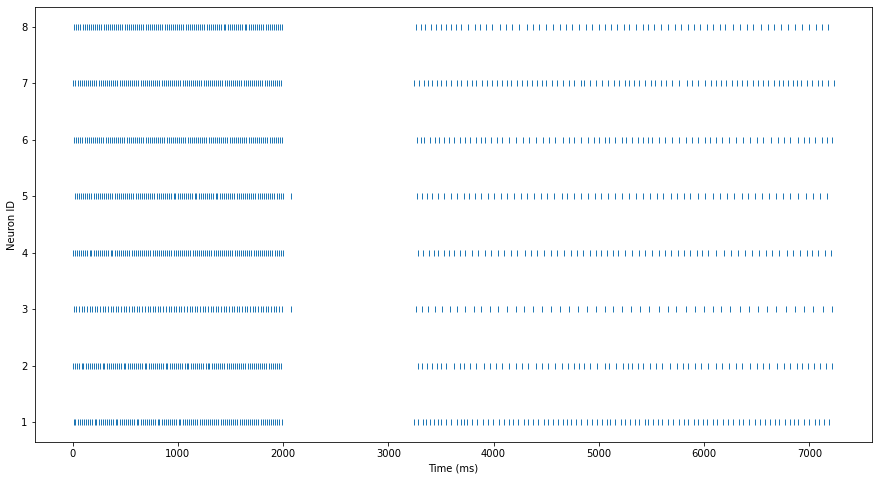

In [29]:
# # set params
parameters.set_all_default_params(model)
parameters.set_param(model, parameters.NEURON_DC_INPUT, (3,30), 0, 0)
parameters.set_param(model, parameters.AMPA_WEIGHT, (6, 40), 0, 0)
#parameters.set_param(model, parameters.AMPA_TIME_CONSTANT, (2,80), 0, 0)

parameters.set_param(model, parameters.ADAPTATION_CASCODE, (0,0), 0, 0)
parameters.set_param(model, parameters.ADAPTATION_WEIGHT, (0,0), 0, 0)
parameters.set_param(model, parameters.ADAPTATION_TIME_CONSTANT, (0,0), 0, 0)
parameters.set_param(model, parameters.ADAPTATION_GAIN, (0,0), 0, 0)

duration1 = 2
duration_stop = 1
duration2 = 4
spikes = []

dynapse.start_graph()
dynapse.run_simulation(0.1) # bug with clearing the buffer at the moment - need to run the simulation for a little 

these_spikes = dynapse.run_simulation(duration1)
spikes_array = np.vstack(([spike.timestamp for spike in these_spikes],[spike.id for spike in these_spikes])).T
pop_freq = len(spikes_array)/duration1/num_neurons
print('Population frequency f is %f Hz.' %pop_freq)
spikes += these_spikes

parameters.set_param(model, parameters.NEURON_DC_INPUT, (0,0), 0, 0)
parameters.set_param(model, parameters.AMPA_WEIGHT, (0, 0), 0, 0)
these_spikes = dynapse.run_simulation(duration_stop)
spikes_array = np.vstack(([spike.timestamp for spike in these_spikes],[spike.id for spike in these_spikes])).T
pop_freq = len(spikes_array)/duration_stop/num_neurons
print('Population frequency f is %f Hz.' %pop_freq)
spikes += these_spikes

parameters.set_param(model, parameters.NEURON_DC_INPUT, (3,30), 0, 0)
parameters.set_param(model, parameters.AMPA_WEIGHT, (6, 40), 0, 0)
parameters.set_param(model, parameters.ADAPTATION_CASCODE, (5,150), 0, 0)
parameters.set_param(model, parameters.ADAPTATION_WEIGHT, (6,130), 0, 0)
parameters.set_param(model, parameters.ADAPTATION_TIME_CONSTANT, (3,100), 0, 0)
parameters.set_param(model, parameters.ADAPTATION_GAIN, (4,125), 0, 0)
these_spikes = dynapse.run_simulation(duration2)
spikes_array = np.vstack(([spike.timestamp for spike in these_spikes],[spike.id for spike in these_spikes])).T
pop_freq = len(spikes_array)/duration2/num_neurons
print('Population frequency f is %f Hz.' %pop_freq)
spikes += these_spikes

dynapse.stop_graph()

spikes = np.vstack(([spike.timestamp for spike in spikes],[spike.id for spike in spikes])).T
spikes[:,0] -= spikes[0,0]

plt.figure(figsize=[15,8])
plt.plot(spikes[:,0]/1000, spikes[:,1], '|')
plt.ylabel('Neuron ID')
plt.xlabel('Time (ms)')
plt.show()


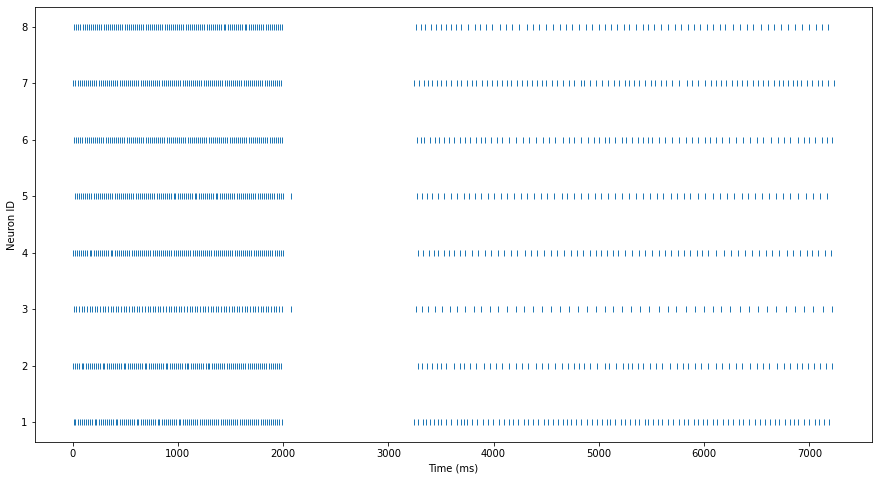

In [36]:
plt.figure(figsize=[15,8])
plt.plot(spikes[:,0]/1000, spikes[:,1], '|')
plt.ylabel('Neuron ID')
plt.xlabel('Time (ms)')
plt.show()

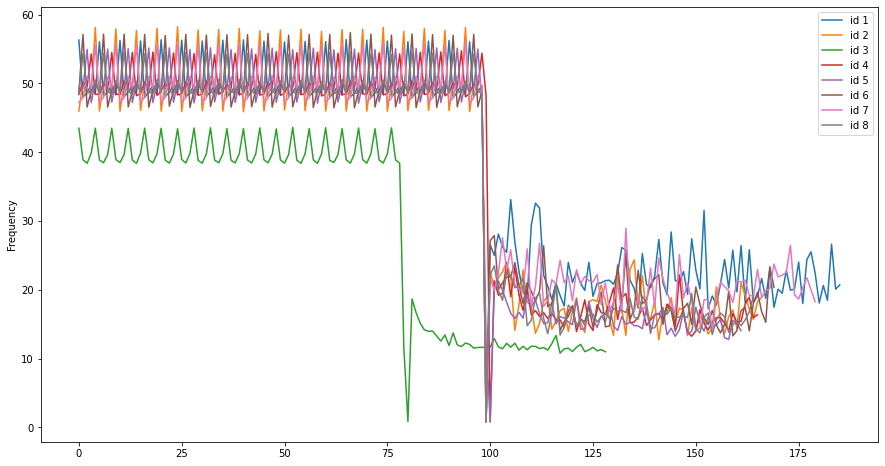

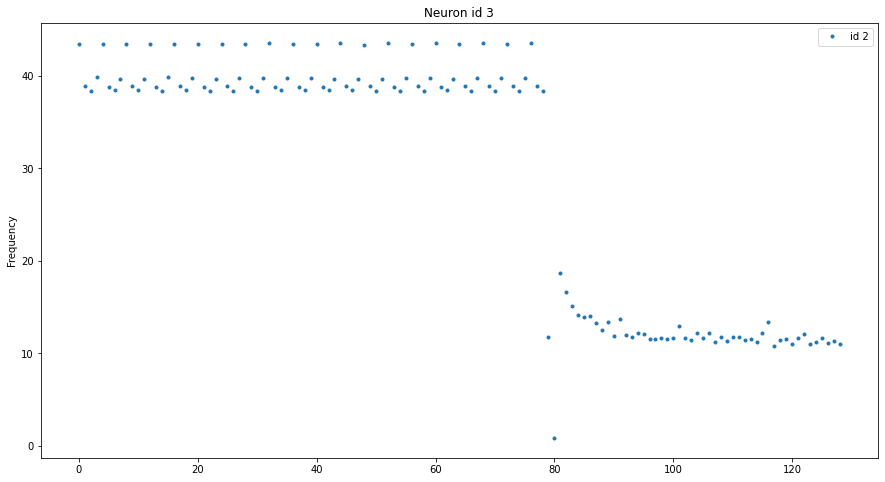

In [35]:
plt.figure(figsize=[15,8])
rates = []
for neuron_id in neuron_ids:
    where_id = np.where(spikes[:,1] == neuron_id)
    neuron_rates = 1e6/np.diff(spikes[where_id,0]) # in sec 
    neuron_rates = neuron_rates[0]
    rates.append(neuron_rates)
    plt.plot(neuron_rates, label = 'id %s' %neuron_id)
plt.legend()
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=[15,8])
id = 2
plt.plot(rates[id], '.', label = 'id %s' %id)
plt.legend()
plt.ylabel('Frequency')
real_id = id + 1
plt.title('Neuron id %s' %real_id)
plt.show()

In [83]:
f0 = all_freqs[0]
l0 = f0.tolist()
f1 = all_freqs[1]
l1 = f1.tolist()
print(l0)
print(l0+l1)

[33.68137420006736, 33.74616137414369, 33.605538192694155, 33.63492650768558, 33.72681281618887, 33.70748643273671, 33.684777848890086, 33.734777181796716, 33.7108953613808, 33.64058400053825, 33.70521419663622, 33.655302392892, 33.66663300003367, 33.69726378218089, 33.662099841788134, 33.68591255137102, 33.76211215773659, 33.654169751632224, 33.738191632928476, 33.656435110393105, 33.78150124991554, 33.650772285223944, 33.67910548295837, 33.80434047731729, 33.704078193461406, 33.62927091740651, 33.656435110393105, 33.68364322285098, 33.689317117542025, 33.72908796546142, 33.68364322285098, 33.72908796546142]
[33.68137420006736, 33.74616137414369, 33.605538192694155, 33.63492650768558, 33.72681281618887, 33.70748643273671, 33.684777848890086, 33.734777181796716, 33.7108953613808, 33.64058400053825, 33.70521419663622, 33.655302392892, 33.66663300003367, 33.69726378218089, 33.662099841788134, 33.68591255137102, 33.76211215773659, 33.654169751632224, 33.738191632928476, 33.656435110393105

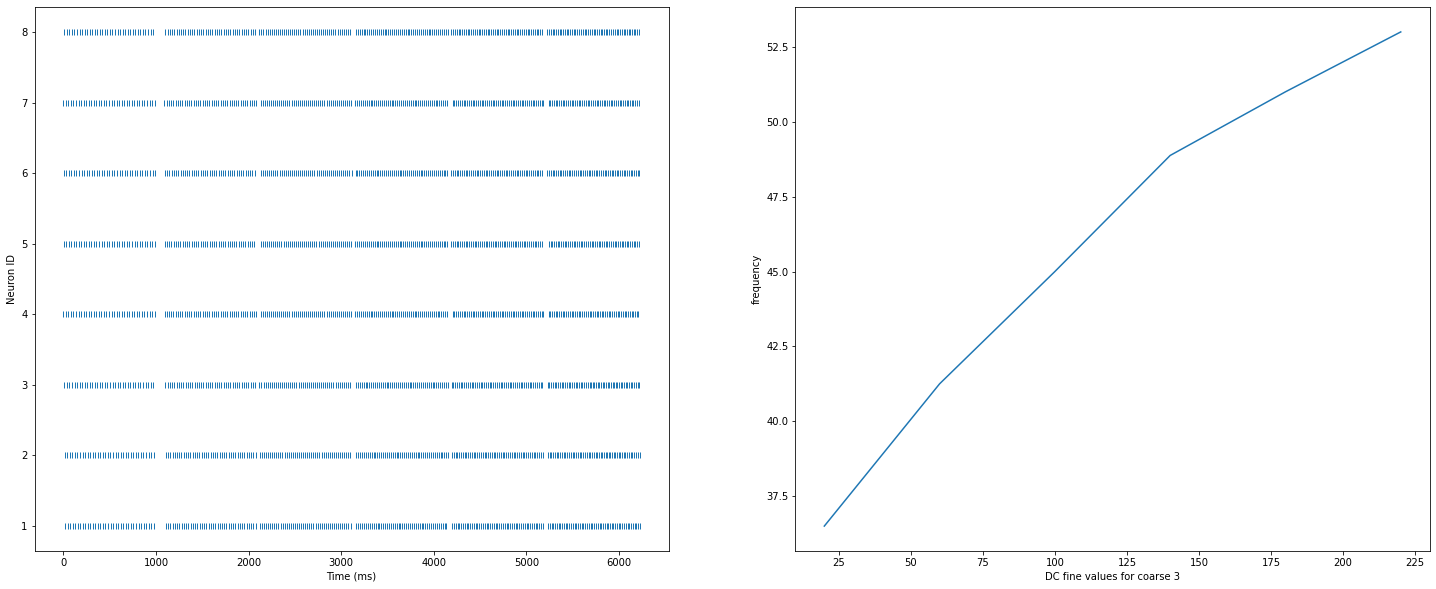

In [37]:
fig, axs = plt.subplots(1,2,figsize=(25,10))
axs[0].plot(spikes[:,0]/1000, spikes[:,1], '|')
axs[1].plot(vary, all_pop_freqs)
axs[0].set_ylabel('Neuron ID')
axs[0].set_xlabel('Time (ms)')
axs[1].set_ylabel('frequency')
axs[1].set_xlabel('DC fine values for coarse 3')
plt.show()

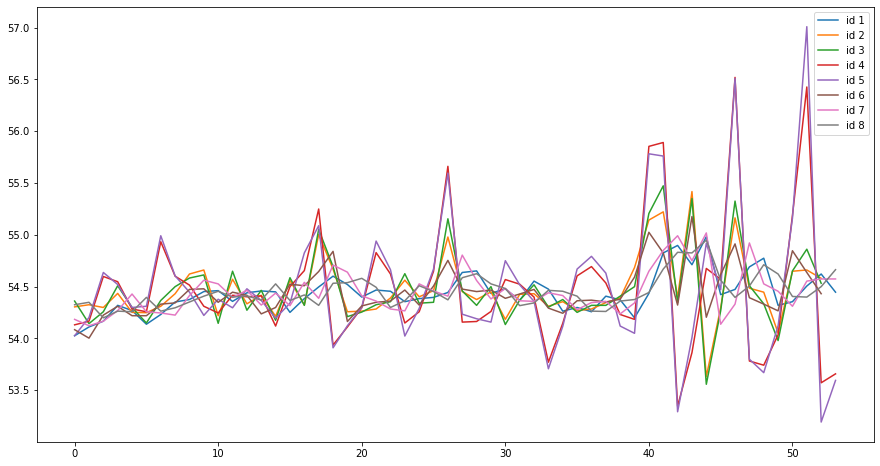

In [34]:
sorted_spikes_array = np.sort(spikes_array, axis=0)

plt.figure(figsize=[15,8])
for neuron_id in neuron_ids:
    where_id = np.where(spikes_array[:,1] == neuron_id)
    neuron_id_freq = 1e6/np.diff(spikes_array[where_id,0]) # in sec 
    neuron_id_freq = neuron_id_freq[0]
    plt.plot(neuron_id_freq, label = 'id %s' %neuron_id)
plt.legend()




# print(spikes_array[:,0])

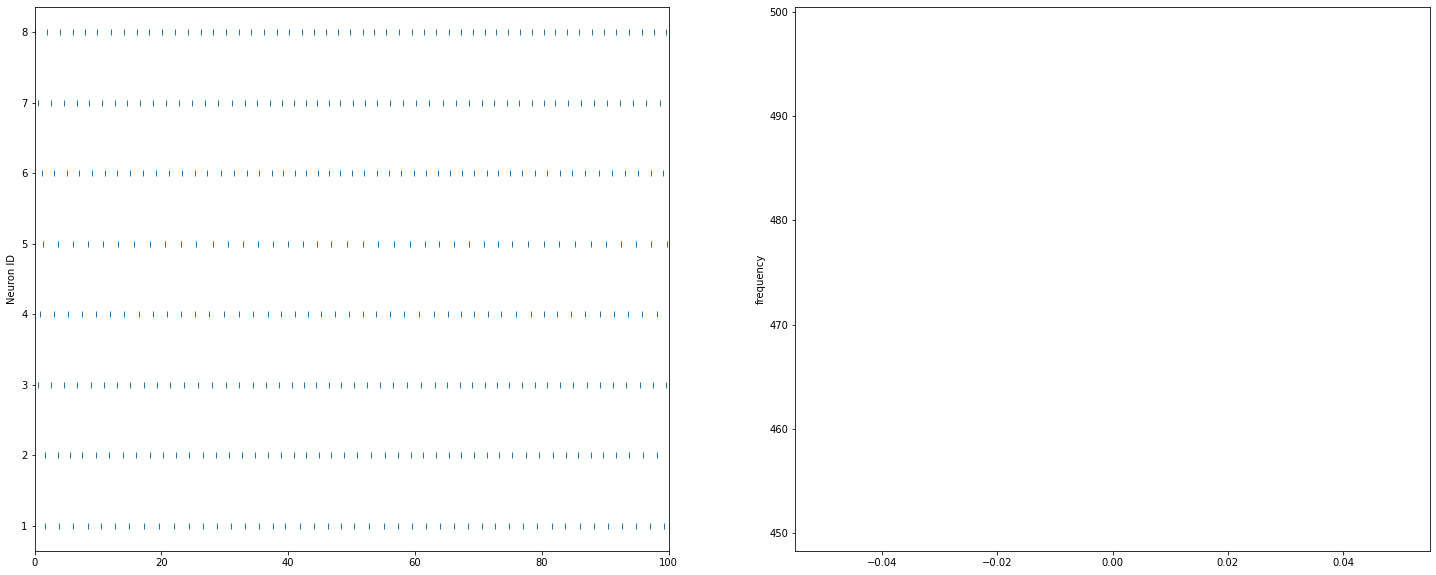

In [61]:
fig, axs = plt.subplots(1,2,figsize=(25,10))
axs[0].plot(spikes_array[:,0]/1000, spikes_array[:,1], '|')
axs[1].plot(pop_spikes)
axs[0].set_xlim([0,100])
axs[0].set_ylabel('Neuron ID')
axs[1].set_ylabel('frequency')
plt.show()

In [82]:
print(spikes[:,1])

[2 7 8 3 1 6 4 5 2 7 8 3 1 6 4 5 2 7 8 3 1 6 4 5 2 7 8 3 1 6 4 5 2 7 8 3 1
 6 4 5 2 7 8 3 1 6 4 5 2 7 8 3 1 6 4 5 2 7 8 3 1 6 4 5 2 7 8 3 1 6 4 5 2 7
 8 3 1 6 4 5 2 7 8 3 1 6 4 5 2 7 8 3 1 6 4 5 2 7 8 3 1 6 4 5 2 7 8 3 1 6 4
 5 2 7 8 3 1 6 4 5 2 7 8 3 1 6 4 5 2 7 8 3 1 6 4 5 2 7 8 3 1 6 4 5 2 7 8 3
 1 6 4 5 2 7 8 3 1 6 4 5 2 7 8 3 1 6 4 5 2 7 8 3 1 6 4 5 2 7 8 3 1 6 4 5 2
 7 8 3 1 6 4 5 2 7 8 3 1 6 4 5 2 7 8 3 1 6 4 5 2 7 8 3 1 6 4 5 2 7 8 3 1 6
 4 5 2 7 8 3 1 6 4 5 2 7 8 3 1 6 4 5 2 7 8 3 1 6 4 5 2 7 8 3 1 6 4 5 2 7 8
 3 1 6 4 5 2 7 8 3 1 6 4 5 2 7 8 3 1 6 4 5 2 7 8 3 1 6 4 5 2 7 8 3 1 6 4 5
 2 7 8 3 1 6 4 5 2 7 8 3 1 6 4 5 2 7 8 3 1 6 4 5 2 7 8 3 1 6 4 5 2 7 8 3 1
 6 4 5 2 7 8 3 1 6 4 5 2 7 8 3 1 6 4 5 2 7 8 3 1 6 4 5 2 7 8 3 1 6 4 5 2 7
 8 3 1 6 4 5 2 7 8 3 1 6 4 5 2 7 8 3 1 6 4 5 2 7 8 3 1 6 4 5 2 7 8 3 1 6 4
 5 2 7 8 3 1 6 4 5 2 7 8 3 1 6 4 5 2 7 8 3]
